In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Python/'

In [0]:
import os
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.exceptions import NotFittedError
from sklearn import metrics
from matplotlib import pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set()

In [0]:
distribution = stats.norm.rvs(size=1000)

In [0]:
kernels = ("tri", "epa", "gau", "cos")
distributions = {"uniform": stats.uniform, "Normal": stats.norm, "Triangular": stats.triang(c=0.5)}

In [0]:
kde = sm.nonparametric.KDEUnivariate(distribution)
kde.fit()

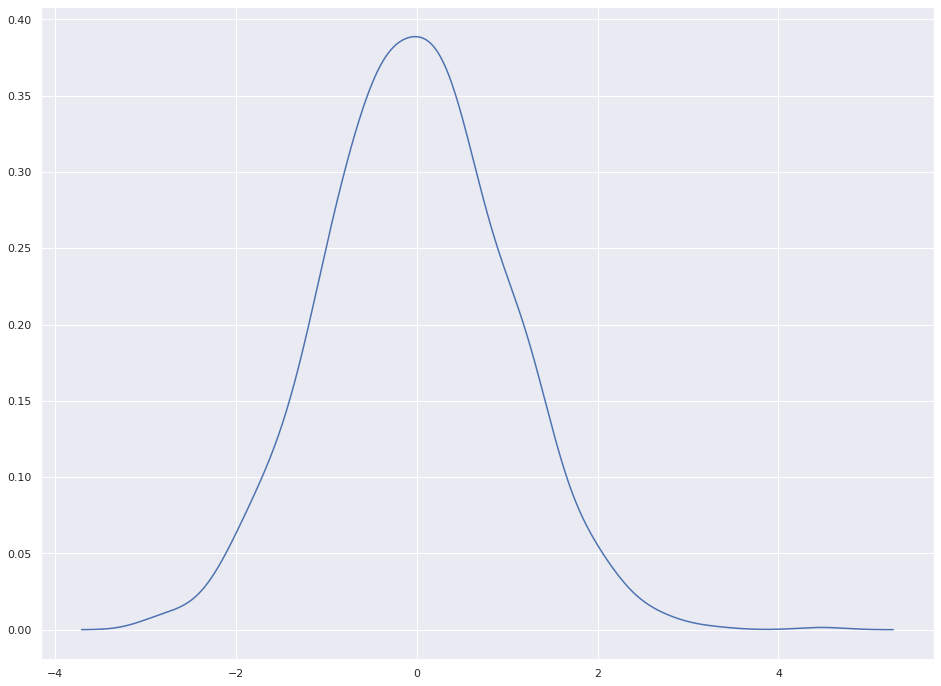

In [0]:
figure = plt.figure(figsize=[16, 12])

_ = plt.plot(kde.support, kde.density)

In [0]:
results = []
for distribution, kernel in product(distributions.keys(), kernels):
    rvs = distributions[distribution].rvs(size=1000)
    kde = sm.nonparametric.KDEUnivariate(rvs)
    kde.fit(kernel=kernel, fft=False)

    mse = metrics.mean_squared_error(y_pred=kde.density, y_true=distributions[distribution].pdf(kde.support))

    results.append([kernel, distribution, f"{mse:.2E}"])

In [0]:
pd.DataFrame.from_records(results, columns=["K", "RVS", "MSE"])

,K,RVS,MSE
0,tri,uniform,2.06E-02
1,epa,uniform,2.34E-02
2,gau,uniform,2.55E-02
3,cos,uniform,2.16E-02
4,tri,Normal,6.86E-05
5,epa,Normal,7.63E-05
6,gau,Normal,5.88E-05
7,cos,Normal,1.24E-04
8,tri,Triangular,1.59E-03
9,epa,Triangular,2.68E-03


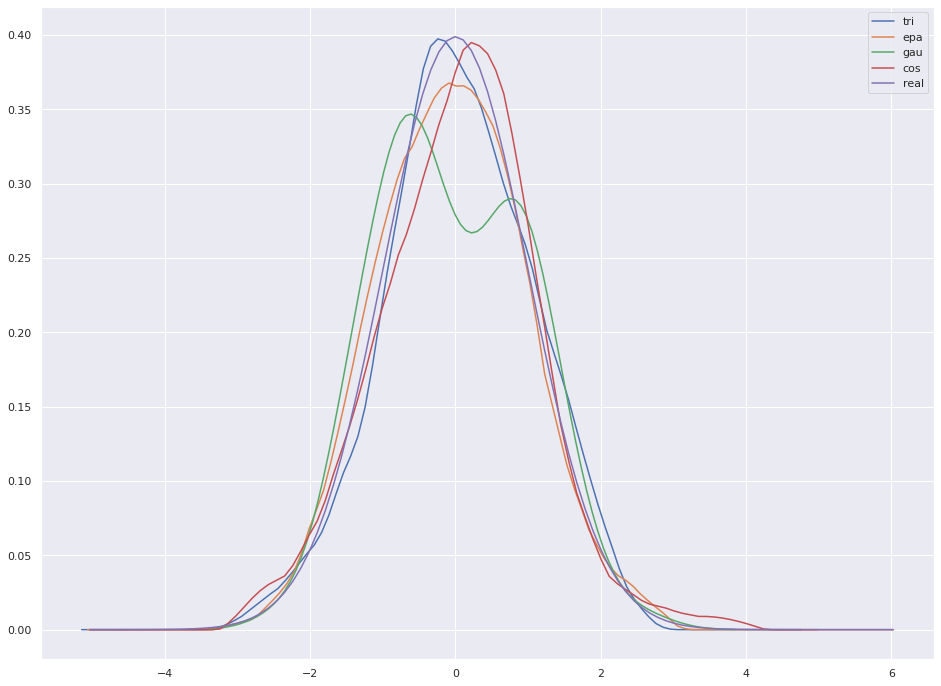

In [0]:
plt.figure(figsize=[16, 12])

for kernel in kernels:
    kde = sm.nonparametric.KDEUnivariate(stats.norm.rvs(size=100))
    kde.fit(kernel=kernel, fft=False)
    plt.plot(kde.support, kde.density)

plt.plot(kde.support, stats.norm.pdf(kde.support))
plt.legend(list(kernels) + ["real"])

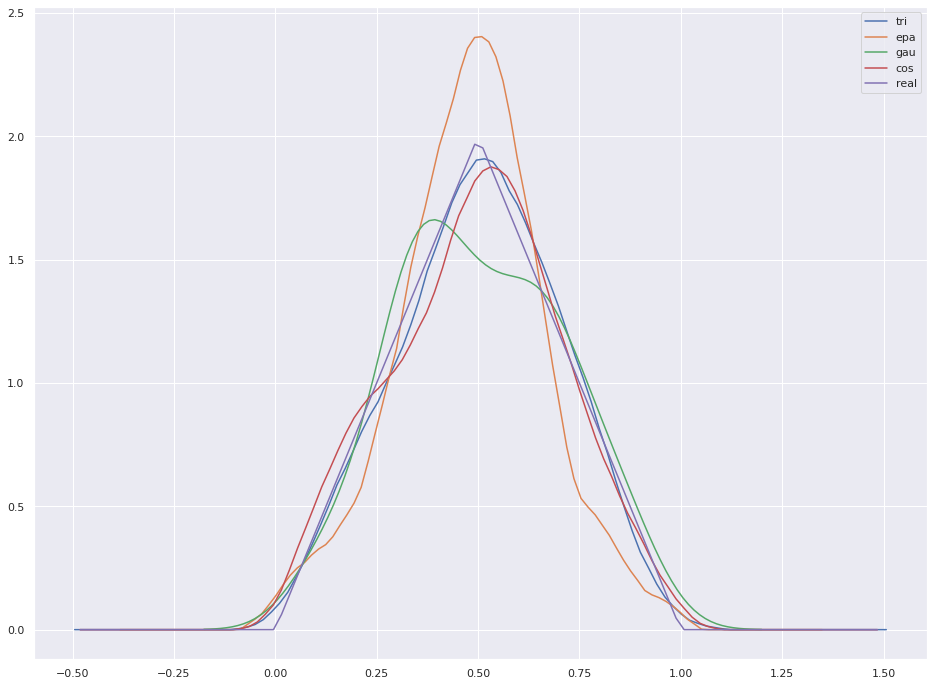

In [0]:
plt.figure(figsize=[16, 12])

for kernel in kernels:
    kde = sm.nonparametric.KDEUnivariate(stats.triang(c=0.5).rvs(size=100))
    kde.fit(kernel=kernel, fft=False)
    plt.plot(kde.support, kde.density)

plt.plot(kde.support, stats.triang(c=0.5).pdf(kde.support))
plt.legend(list(kernels) + ["real"])

In [0]:
class KernelDensityEstimator:
    def __init__(self, kernel: str, width: float = None, precision: int = 10_000):
        self._distribution = None
        self._spacing = None
        self._kernel = kernel
        self.width = width
        self._precision = precision

    def fit(self, realization: np.array) -> None:
        """
        :param realization: random variable realization for which
                            probability density  will be estimated,
                            must have at least 2 samples
        """
        self._distribution = realization
        self._spacing = np.linspace(realization.min(), realization.max(), self._precision)
        self.bins = self._distribution.shape[0]
        self._values = np.sum(np.vectorize(
            lambda point: self._kernel(self._spacing - point, self.width), signature='()->(n)')(distribution)
            , axis=0)

    def _estimate(self, x: float) -> float:
        nearest_value = np.argmin(np.abs(self._spacing - x))
        return (1 / (self.width * self.bins)) * self._values[nearest_value]

    def predict(self, values: float) -> float:
        return np.vectorize(self._estimate)(values)